ribosome number analysis
01.25

@author: jennifer love

This script calculates the number of ribosomes present on an mRNA using the SunTag method; colocalised mRNA and neongreen (protein) signals represent translating mRNAs. Through normalisation of the number of single protein and mRNA molcules in a translation site, the number of ribosomes per mRNA is calculated.

This first portion of this script is adapted from DaisyVinter/thesis/ribosome_number.ipynb but differs in terms of the ribosome number calculation.

In [12]:
# load relevant packages
import pandas as pd
import scipy.spatial.distance
import scipy.optimize
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#setting global plotting parameters
mpl.rc('font',family='Arial', size=14)
csfont = {'fontname': 'Arial'}

# output directory
folder = ''

# specify file locations
mrna_file = '' # mRNA data
bright_file = '' # single protein neongreen foci 
single_file = '' # bright neongreen foci (translation sites)

# input image voxels
xy_pixel = 0.014
z_pixel = 0.2

Read in and prepare data

In [2]:
# read in data and rename columns, remove -8 intensity values
mrna = pd.read_csv(mrna_file, sep = '  ', engine = 'python', names = ['x', 'y', 'z', 'intensity', ''])
brights = pd.read_csv(bright_file, sep = '  ', engine = 'python', names = ['x', 'y', 'z', 'intensity', ''])
singles = pd.read_csv(single_file, sep = '  ', engine = 'python', names = ['x', 'y', 'z', 'intensity', ''])
mrna = mrna.loc[mrna['intensity'] != -8]
brights = brights.loc[brights['intensity'] != -8]
singles = singles.loc[singles['intensity'] != -8]

# convert to um using pixel dimensions
mrna['x'] = mrna['x']*xy_pixel
mrna['y'] = mrna['y']*xy_pixel
mrna['z'] = mrna['z']*z_pixel
brights['x'] = brights['x']*xy_pixel
brights['y'] = brights['y']*xy_pixel
brights['z'] = brights['z']*z_pixel
singles['x'] = singles['x']*xy_pixel
singles['y'] = singles['y']*xy_pixel
singles['z'] = singles['z']*z_pixel

# remove bright translation sites from the full data to give just single proteins
just_singles = singles[~singles.isin(brights)].dropna()

# create data just based on position, without intensity etc

mrna_pos = np.array(mrna[['x', 'y', 'z']])
singles_pos = np.array(singles[['x', 'y', 'z']])
brights_pos = np.array(brights[['x', 'y', 'z']])

Assess colocalisation of mRNAs and single protein signals

In [3]:
# assess colocalisation of singles and mRNAs

distances = scipy.spatial.distance.cdist(singles_pos, mrna_pos, metric = 'euclidean')
opt_index = scipy.optimize.linear_sum_assignment(distances)

min_dist = []
for i in zip(opt_index[0], opt_index[1]):
    min_dist.append(distances[i])

for i in zip(opt_index[0], opt_index[1]):
    singles.loc[i[0], 'closest_mrna'] = i[1]
    mrna.loc[i[1], 'closest_ng'] = i[0]
    singles.loc[i[0], 'distance'] = distances[i]
    mrna.loc[i[1], 'distance'] = distances[i]

coloc = singles.loc[singles['distance'] <= 0.4]
non_coloc = singles[~singles.isin(coloc)].dropna(subset = ['x'])

print(coloc)

              x          y         z    intensity       closest_mrna  distance
0      2.521435   9.008597  2.826460  242264.8300  0.0          28.0  0.076180
1      6.063649   2.946909  3.709127  183349.7900  0.0         254.0  0.141308
2     15.038078   8.239662  2.826308  159485.4200  0.0          76.0  0.117092
3      5.771552  10.577196  2.494961  158206.2900  0.0         158.0  0.075810
5      4.423361  13.103161  6.760079  145390.6400  0.0         451.0  0.078927
...         ...        ...       ...          ...  ...           ...       ...
7606  13.728655  13.033349  6.810947    1615.5205  0.0         700.0  0.317520
7608  13.484524   0.024414  7.093051    1592.5241  0.0         809.0  0.223943
7624   0.021242  13.673065  7.948875    1469.0588  0.0        1120.0  0.155624
7630  15.217090   7.514636  5.099355    1435.1043  0.0        1403.0  0.390462
7638   6.453901  14.863552  6.779960    1386.4576  0.0         948.0  0.220375

[1118 rows x 7 columns]


Assess colocalisation of mRNAs and bright neongreen foci

In [4]:
# assess colocalisation of translation sites and mRNAs

distances_bright = scipy.spatial.distance.cdist(brights_pos, mrna_pos, metric = 'euclidean')
opt_index_bright = scipy.optimize.linear_sum_assignment(distances_bright)

min_dist = []
for i in zip(opt_index_bright[0], opt_index_bright[1]):
    min_dist.append(distances_bright[i])

for i in zip(opt_index_bright[0], opt_index_bright[1]):
    brights.loc[i[0], 'closest_mrna'] = i[1]
    mrna.loc[i[1], 'closest_bright'] = i[0]
    brights.loc[i[0], 'distance'] = distances_bright[i]
    mrna.loc[i[1], 'distance_to_bright'] = distances_bright[i]

bright_coloc = brights.loc[brights['distance'] <= 0.4]
bright_no_coloc = brights[~brights.isin(bright_coloc)].dropna(subset = ['x'])

Calculate ribosome number, taking into account number of mRNAs in each translation site (important for aggregates of mRNAs)

In [5]:
# retrieve the mRNA intensity data

mrna['IDs'] = [str(i) for i in range(0, mrna.shape[0])]
print(mrna)
mrna = mrna.rename(columns={"intensity": "mrna_intensity"})
mrna['IDs'] = mrna['IDs'].astype(float)

# merge the colocalised translation sites with the mRNA data to give paired measurements of intensity

coloc_brights_mRNAs = bright_coloc.merge(mrna, left_on='closest_mrna', right_on='IDs')
print(coloc_brights_mRNAs)

# merge the colocalised single proteins with the mRNA data to give paired measurements of intensity

coloc_singles_mRNAs = coloc.merge(mrna, left_on='closest_mrna', right_on='IDs')
print(coloc_singles_mRNAs)

              x          y          z      intensity       closest_ng  \
0      7.409374   0.408725   5.609327  125043.990000  0.0      4922.0   
1      8.594835  11.105344   4.899188  113090.100000  0.0      1067.0   
2      2.888920  12.845323   5.702648  111765.140000  0.0      7227.0   
3      6.903240   7.693378   5.376440  106457.640000  0.0      4899.0   
4      2.851314  13.019270   5.776153   86473.707000  0.0      3017.0   
...         ...        ...        ...            ...  ...         ...   
1774  13.948655   6.920365  10.211299      15.535040  0.0      3781.0   
1775   9.397767  10.709658   5.652876      14.448876  0.0      4709.0   
1776  11.008440  14.895692   2.777001      14.109966  0.0      3798.0   
1777  11.349011  10.889826   4.838968      13.774687  0.0      6695.0   
1778   4.196058   7.525940   3.513815       9.369816  0.0      2882.0   

      distance  closest_bright  distance_to_bright   IDs  
0     0.439301             NaN                 NaN     0  
1    

In [6]:
# extract the intensities of a single protein and a single mRNA for normalisation

single_protein = just_singles['intensity'].median()
print(single_protein)
single_mrna = mrna['mrna_intensity'].median()
print(single_mrna)

5629.2823
2817.1673


Plot the distributions of mRNAs and single proteins to ensure the median is representative for normalisation

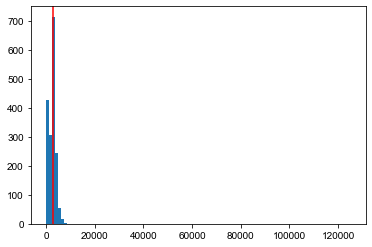

In [7]:
# plotting the median mRNA intensity on the distribution (to check its at the peak)
plt.hist(mrna['mrna_intensity'], bins=100)
plt.axvline(x = single_mrna, c = 'red')
plt.show()

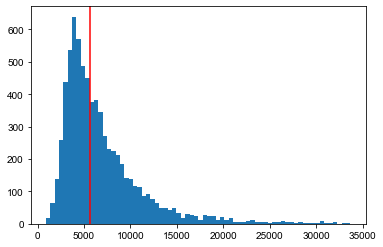

In [8]:
# plotting the median single protein intensity on the distribution (to check its at the peak)
plt.hist(just_singles['intensity'], bins=70)
plt.axvline(x = single_protein, c = 'red')
plt.show()

In [9]:
# normalise the full protein data 
coloc_singles_mRNAs['mrna_intensity_norm'] = coloc_singles_mRNAs['mrna_intensity']/single_mrna
coloc_singles_mRNAs['TS_intensity_norm'] = coloc_singles_mRNAs['intensity']/single_protein

# normalise the bright TS data
coloc_brights_mRNAs['mrna_intensity_norm'] = coloc_brights_mRNAs['mrna_intensity']/single_mrna
coloc_brights_mRNAs['TS_intensity_norm'] = coloc_brights_mRNAs['intensity']/single_protein

coloc_brights_mRNAs['mrna_intensity_norm'] = coloc_brights_mRNAs['mrna_intensity_norm'].round()

Plot the normalised intensities of bright translation sites against mRNAs to visualise the relationship and inspect the data

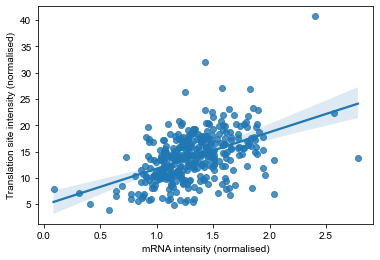

4.792532829680736 6.94006983173687


In [10]:
# Plot the normalised intensities of bright translation sites against mRNAs

plt.figure(figsize=(6,4))
p = sns.regplot(data=coloc_brights_mRNAs, x="mrna_intensity_norm", y="TS_intensity_norm")
plt.ylabel('Translation site intensity (normalised)')
plt.xlabel('mRNA intensity (normalised)')
plt.show()

# get the parameters of the regression
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(), y=p.get_lines()[0].get_ydata())
print(intercept, slope)

Calculate ribosome number:

In [18]:
# Calculate ribosome number (new method - taking into account there could be more than one mRNA per translation site)

correction_factor = (575*0.5 + 759)/(575 + 759) # 

ribosome_number = (coloc_brights_mRNAs['TS_intensity_norm']/coloc_brights_mRNAs['mrna_intensity_norm'])/correction_factor
ribosome_number = pd.DataFrame(ribosome_number)
ribosome_number.columns = (['Ribosome_number'])
print(ribosome_number)

ribosome_number.to_csv(folder + '/ribo_numbers.csv')

     Ribosome_number
0          21.601150
1          28.621763
2          21.740214
3          18.753502
4          26.776693
..               ...
355         5.199527
356         5.403907
357        15.632986
358         5.424103
359         8.680780

[360 rows x 1 columns]
